loading file 1
finished loading file 1 in 203.4416539669037s
loading file 2
finished loading file 2 in 81.48734831809998s
loading file 3
finished loading file 3 in 152.26751685142517s
loading file 4
finished loading file 4 in 360.76629185676575s
loading file 5
finished loading file 5 in 265.8937985897064s
loading file 1
finished loading file 1 in 45.53381013870239s
loading file 2
finished loading file 2 in 11.730885028839111s
loading file 3
finished loading file 3 in 12.13563346862793s
loading file 4
finished loading file 4 in 64.84292435646057s
loading file 5
finished loading file 5 in 86.42567873001099s
loading file 1
finished loading file 1 in 160.65023255348206s
loading file 2
finished loading file 2 in 11.80672550201416s
loading file 3
finished loading file 3 in 13.261651992797852s
loading file 4
finished loading file 4 in 119.08076357841492s
loading file 5
finished loading file 5 in 192.43819308280945s


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


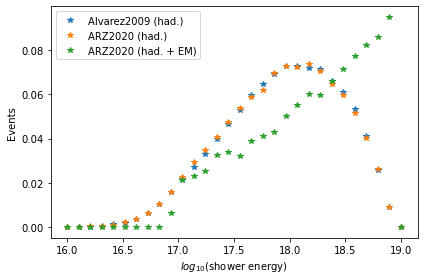

In [2]:

# Imports
import matplotlib.pyplot as plt
import numpy as np
from toolbox import get_pred_energy_diff_data, common_dir, calculate_percentage_interval
import sys
import argparse
import os
import time
import pickle
from NuRadioReco.utilities import units
from scipy import stats
from radiotools import stats as rtSTATS
from mpl_toolkits.mplot3d import Axes3D
from itertools import product, combinations
from radiotools import plthelpers as php
from tensorflow import keras
from radiotools import helper as hp
import datasets
# -------

file_ids_to_load = [1, 2, 3, 4, 5]
# file_ids_to_load = [1]

# Create figure
fig = plt.figure()

# Calculate binned statistics
ax = fig.add_subplot(1, 1, 1)

for dataset_to_use in ["ALVAREZ-HAD", "ARZ-HAD", "ARZ-EM"]:

    if dataset_to_use == "ALVAREZ-HAD":
        dataset_title = "Alvarez2009 (had.)"
        dataset_name = "ALVAREZ"
        dataset_em = False
        dataset_noise = True
    if dataset_to_use == "ARZ-HAD":
        dataset_title = "ARZ2020 (had.)"
        dataset_name = "ARZ"
        dataset_em = False
        dataset_noise = True
    if dataset_to_use == "ARZ-EM":
        dataset_title = "ARZ2020 (had. + EM)"
        dataset_name = "ARZ"
        dataset_em = True
        dataset_noise = True

    dataset = datasets.Dataset(dataset_name, dataset_em, dataset_noise)

    # Loading data and label files
    def load_file(i_file, norm=1e-6):
        # Load 500 MHz filter
        filt = np.load(f"{common_dir()}/bandpass_filters/500MHz_filter.npy")

        t0 = time.time()
        print(f"loading file {i_file}", flush=True)
        data = np.load(os.path.join(dataset.datapath, f"{dataset.data_filename}{i_file:04d}.npy"), allow_pickle=True)
        data = np.fft.irfft(np.fft.rfft(data, axis=-1) * filt, axis=-1)
        data = data[:, :, :, np.newaxis]

        labels_tmp = np.load(os.path.join(dataset.datapath, f"{dataset.label_filename}{i_file:04d}.npy"), allow_pickle=True)
        print(f"finished loading file {i_file} in {time.time() - t0}s")
        
        shower_energy_data = np.array(labels_tmp.item()["shower_energy"])

        # check for nans and remove them
        idx = ~(np.isnan(data))
        idx = np.all(idx, axis=1)
        idx = np.all(idx, axis=1)
        idx = np.all(idx, axis=1)
        data = data[idx, :, :, :]
        shower_energy_data = shower_energy_data[idx]
        data /= norm

        # Get log10 of energy
        shower_energy_log10 = np.log10(shower_energy_data)

        return data, shower_energy_log10


    # Load test file data
        # Load first file
    data, shower_energy_log10 = load_file(file_ids_to_load[0])

        # Then load rest of files
    if len(file_ids_to_load) > 1:
        for test_file_id in file_ids_to_load:
            if test_file_id != file_ids_to_load[0]:
                data_tmp, shower_energy_log10_tmp = load_file(test_file_id)

                data = np.concatenate((data, data_tmp))
                shower_energy_log10 = np.concatenate((shower_energy_log10, shower_energy_log10_tmp))


    
    nu_energy_bins = np.logspace(np.log10(1e16),np.log10(10**19), 30)
    nu_energy_bins_with_one_extra = np.append(np.logspace(np.log10(1e16),np.log10(10**19), 30), [1e20])
    binned_resolution_nu_energy_count = stats.binned_statistic(shower_energy_log10, shower_energy_log10, bins = np.log10(nu_energy_bins_with_one_extra), statistic = "count")[0]
    
    sumTOTAL = np.sum(binned_resolution_nu_energy_count)

    ax.plot(np.log10(nu_energy_bins), binned_resolution_nu_energy_count / sumTOTAL, "*", label=dataset_title)
    # ax.set_ylim(0, 0.4)
    ax.set_xlabel("$log_{10}$(shower energy)")
    ax.set_ylabel("Events")
    # ax.set_xscale('log')

plt.legend()
plt.tight_layout()
plt.savefig(f"SAMEPLOT_counts_plot.png", dpi=300)
plt.savefig(f"SAMEPLOT_counts_plot.eps", format="eps")
    